In [ ]:
import os
os.chdir("../")
print(os.getcwd())

In [ ]:
import jax
print(jax.devices())

In [ ]:
import jax.numpy as jnp

# Ensure JAX is using GPU
from jax.lib import xla_bridge
print("JAX is using:", xla_bridge.get_backend().platform)

# Define a simple function to compute on GPU
def compute_on_gpu(x):
    return jnp.sin(x) * jnp.cos(x)

# Generate some data
x = jnp.linspace(0, 10, 1000)

# Run the computation
result = compute_on_gpu(x)

# Print the result
print(result)

In [ ]:
!(python run_files/main_train_eval.py --imag_horizon 5 --envs.amount 2 --jax.platform gpu --loss_scales.reward 10 \
               --run.eval_every 20 \
               --KS.max_episode_steps 250 \
               --logdir_dirname Test \#Notebook_Exp/Model_Size_Test \
               --logdir_expname ks_test_gpu) #ks_medium_imag5_burnin2000_env2_rs10_tl250) 
               #--rssm.deter 1024)# --.*\.units=256 --.*\.layers=2)

## Evaluate model from logdir

In [2]:
base_dir = '/rds/general/user/pg221/home/PhD_projects2/dreamer_flows/dreamer/logdir'

# Experiment_dir = 'Experiments/TimeLimit_test'
# checkpoint_file = 'ks_rssm2048_units768_layers4_imag5_burnin1500_env58_rs10_tl250/checkpoint.ckpt'
# logdir = 'Test_ks_rssm2048_units768_layers4_imag5_burnin1500_env58_rs10_tl250'

Experiment_dir = '/Experiments/TimeLimit_test'
checkpoint_list = []
logdir_list = []
for folder_name in os.listdir(base_dir+Experiment_dir):
    checkpoint_list.append(folder_name+"/checkpoint.ckpt")
    logdir_list.append("Test_"+folder_name)

# checkpoint_file = 'ks_rssm2048_units768_layers4_imag5_burnin1500_env58_rs10_tl250/checkpoint.ckpt'
# logdir = 'Test_ks_rssm2048_units768_layers4_imag5_burnin1500_env58_rs10_tl250'

In [ ]:
# !(python main_eval.py --run.steps 1 --imag_horizon 15 \
#                     --envs.amount 1 --jax.platform cpu \
#                     --loss_scales.reward 10 --KS.max_episode_steps 1100 \
#                     --rssm.deter 2048 --.*\.units=768 --.*\.layers=4 \
#                     --run.from_checkpoint {base_dir}/{Experiment_dir}/{checkpoint_file} \
#                     --logdir {base_dir}/{Experiment_dir}/{logdir})

#'/Experiments/Num_Env_Test_largemodel'
for i in range(len(checkpoint_list)):
    !(python main_eval.py --run.steps 1 --imag_horizon 5 \
                        --envs.amount 1 --jax.platform cpu \
                        --loss_scales.reward 1 --KS.max_episode_steps 1100 \
                        --rssm.deter 2048 --.*\.units=768 --.*\.layers=4 \
                        --run.from_checkpoint {base_dir}{Experiment_dir}/{checkpoint_list[i]} \
                        --logdir {base_dir}{Experiment_dir}/{logdir_list[i]})

#'/Experiments/Num_Env_Test'
# for i in [1]:#range(len(checkpoint_list)):
#     !(python main_eval.py --run.steps 1 --imag_horizon 15 \
#                         --envs.amount 1 --jax.platform cpu \
#                         --loss_scales.reward 1 --KS.max_episode_steps 1100 \
#                         --rssm.deter 128 --.*\.units=512 --.*\.layers=4 \
#                         --run.from_checkpoint {base_dir}/{Experiment_dir}/{checkpoint_list[i]} \
#                         --logdir {base_dir}/{Experiment_dir}/{logdir_list[i]})

#'/Experiments/Num_Env_Test'
# for i in [1]:#range(len(checkpoint_list)):
#     !(python main_eval.py --run.steps 1 --imag_horizon 5 \
#                         --envs.amount 1 --jax.platform cpu \
#                         --loss_scales.reward 10 --KS.max_episode_steps 1100 \
#                         --run.from_checkpoint {base_dir}/{Experiment_dir}/{checkpoint_list[i]} \
#                         --logdir {base_dir}/{Experiment_dir}/{logdir_list[i]})

#                         --rssm.deter 2048 --.*\.units=768 --.*\.layers=4 \

In [ ]:
import os
import json
import pandas as pd

def read_json_files_from_folders(base_directory):
    folder_df_dict = {}
    
    # Iterate over each folder in the base directory
    for folder_name in os.listdir(base_directory):
        if folder_name.split("_")[0] == "Test":
            folder_path = os.path.join(base_directory, folder_name)

            # Check if the path is a directory
            if os.path.isdir(folder_path):
                jsonl_file_path = os.path.join(folder_path, 'metrics.jsonl')  # Adjust the file name as needed

                # Check if the JSON file exists in the folder
                if os.path.isfile(jsonl_file_path):
                    with open(jsonl_file_path, 'r') as jsonl_file:
                        json_list = []
                        for line in jsonl_file:
                            try:
                                json_data = json.loads(line)
                                json_list.append(json_data)
                            except json.JSONDecodeError:
                                print(f"Error decoding JSON from line in file: {jsonl_file_path}")
            
#             if json_list:
#                     df = pd.DataFrame(json_list)
#                     folder_df_dict[folder_name] = df
            
            folder_df_dict[folder_name]= json_list
                    
    
    return folder_df_dict

# Specify the base directory containing the folders
base_directory = base_dir+Experiment_dir  # Change to your base directory path

# Read JSON files and form the dictionary
folder_df_dict = read_json_files_from_folders(base_directory)

# Print the resulting dictionary
# print(json.dumps(folder_json_dict, indent=2))
df = pd.DataFrame(folder_df_dict[list(folder_df_dict.keys())[2]])
df

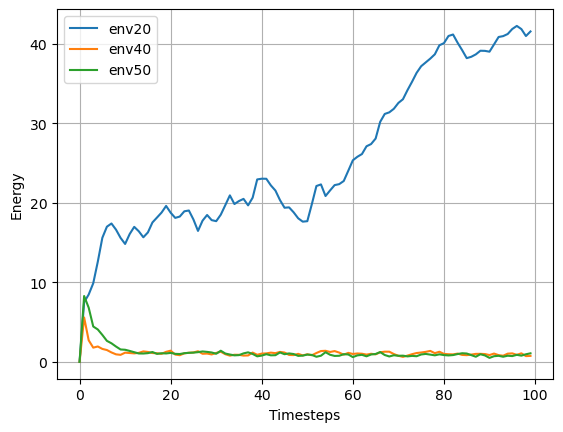

In [50]:
import matplotlib.pyplot as plt

plt.figure()

for keys,v in folder_df_dict.items():
    df = pd.DataFrame(v)
    plt.plot(-df['eval_rollout_episode/reward'][:100],label = keys.split("_")[-1])

plt.xlabel("Timesteps")
plt.ylabel("Energy")
plt.legend()
plt.grid()

## Evaluate model and actions

In [62]:
import warnings
import dreamerv3
from dreamerv3 import embodied
warnings.filterwarnings('ignore', '.*truncated to dtype int32.*')
print("Reading config", flush =True)

# See configs.yaml for all options.
config = embodied.Config(dreamerv3.configs['defaults'])
config = config.update(dreamerv3.configs['medium'])
config = config.update({
  'logdir': '~/PhD_projects2/dreamer_flows/dreamer/logdir/old_ks_test/ks_test_run_negreward_wl100',
  'run.train_ratio': 64,
  'run.log_every': 30,  # seconds
  'batch_size': 16,
  'batch_length': 64,
  'jax.prealloc': False,
    
  'KS.max_episode_steps': 100,
    
#    'rssm.deter': 2048,
# # #   '.*\.cnn_depth': 32
#   '.*\.units': 768,
#   '.*\.layers': 4,
    
  'encoder.mlp_keys': 'vector',
#   'encoder.mlp_units': 512,

  'decoder.mlp_keys': 'vector',
#   'decoder.mlp_units': 512,
    
  'encoder.cnn_keys': '$^',
  'decoder.cnn_keys': '$^',
    
  'model_opt.lr': 1e-4,
  'imag_horizon': 5,
    
    
  'jax.platform': 'cpu',
#   'wrapper.length': 0,
})

# config = embodied.Flags(config).parse()

logdir = embodied.Path(config.logdir)
step = embodied.Counter()
logger = embodied.Logger(step, [
  embodied.logger.TerminalOutput(),
  embodied.logger.JSONLOutput(logdir, 'metrics.jsonl'),
  embodied.logger.TensorBoardOutput(logdir),
  # embodied.logger.WandBOutput(logdir.name, config),
  # embodied.logger.MLFlowOutput(logdir.name),
])

Reading config


In [63]:
import gym
from embodied.envs import from_gym

from ks.KS_environment import KSenv
from gym.wrappers.time_limit import TimeLimit

import numpy as np

env = TimeLimit(KSenv(nu=0.08,
              actuator_locs=np.linspace(0.2, 2 * np.pi - 0.2, 7),
              # sensor_locs=np.array([0, 2 * np.pi, 64]),
              burn_in=1500), max_episode_steps = config.KS.max_episode_steps)

KS Env Initiated


/rds/general/user/pg221/home/anaconda3/envs/dreamer_flows/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [64]:
#collecting burnin data
_, u_hist = env.burnin_reset()

In [65]:
env = from_gym.FromGym(env, obs_key='vector')  # Or obs_key='vector'.
env = dreamerv3.wrap_env(env, config)
env = embodied.BatchEnv([env], parallel=False)

In [66]:
agent = dreamerv3.Agent(env.obs_space, env.act_space, step, config)

Encoder CNN shapes: {}
Encoder MLP shapes: {'vector': (64,)}
Decoder CNN shapes: {}
Decoder MLP shapes: {'vector': (64,)}
JAX devices (1): [CpuDevice(id=0)]
Policy devices: TFRT_CPU_0
Train devices:  TFRT_CPU_0


/rds/general/user/pg221/home/anaconda3/envs/dreamer_flows/lib/python3.9/site-packages/jax/_src/pjit.py:379: DeprecationWarning: backend and device argument on jit is deprecated. You can use a `jax.sharding.Mesh` context manager or device_put the arguments before passing them to `jit`. Please see https://jax.readthedocs.io/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization.html for more information.
  warnings.warn(


Tracing train function.
Optimizer model_opt has 24,130,496 variables.
Optimizer actor_opt has 2,142,734 variables.
Optimizer critic_opt has 2,297,215 variables.


In [67]:
replay = embodied.replay.Uniform(
  config.batch_length, config.replay_size, logdir / 'replay')

args = embodied.Config(
  **config.run, logdir=config.logdir,
  batch_steps=config.batch_size * config.batch_length)

Train the Model

In [68]:
# embodied.run.train(agent, env, replay, logger, args)


Loading Checkpoint Model

In [69]:
checkpoint = embodied.Checkpoint()
checkpoint.agent = agent
checkpoint.load('logdir/old_ks_test/ks_test_run_negreward_wl100/checkpoint.ckpt', keys=['agent'])

Loading checkpoint: logdir/old_ks_test/ks_test_run_negreward_wl100/checkpoint.ckpt
Loaded checkpoint from 1327476 seconds ago.


In [70]:
agent

<dreamerv3.jaxagent.Wrapper.<locals>.Agent at 0x149f48aee1c0>

Evaluating model with the environment

In [71]:
policy = lambda *args: agent.policy(*args, mode='eval')

In [72]:
from embodied.core.basics import convert
import collections

#initializing actions

_acts = {k: convert(np.zeros((len(env),) + v.shape, v.dtype))
        for k, v in env.act_space.items()}
_acts['reset'] = np.ones(len(env), bool)
_eps = [collections.defaultdict(list) for _ in range(len(env))]
_state = None


print(np.ones(len(env), bool))

[ True]


In [73]:
from tqdm import tqdm
obs_total = [] 
acts_total = []
control_time = 100
# acts['reset'] = [True]
# obs = env.reset()
for i in tqdm(range(control_time)):
    #take a step
    assert all(len(x) == len(env) for x in _acts.values())
    acts = {k: v for k, v in _acts.items() if not k.startswith('log_')}
    obs  = env.step(acts)

    #read observation
    obs = {k: convert(v) for k, v in obs.items()}
    assert all(len(x) == len(env) for x in obs.values()), obs
    acts, _state = policy(obs, _state)
    acts = {k: convert(v) for k, v in acts.items()}
    
    acts['reset'] = obs['is_last'].copy()
    _acts = acts
    acts_total.append(acts)
#     print(f"{i}: obs: ", obs)
    obs_total.append(obs)
    

  0%|          | 0/100 [00:00<?, ?it/s]

Tracing policy function.
Tracing policy function.


  1%|          | 1/100 [00:04<07:16,  4.41s/it]


Tracing policy function.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:16                                                                                   │
│                                                                                                  │
│   13 │   #read observation                                                                       │
│   14 │   obs = {k: convert(v) for k, v in obs.items()}                                           │
│   15 │   assert all(len(x) == len(env) for x in obs.values()), obs                               │
│ ❱ 16 │   acts, _state = policy(obs, _state)                                                      │
│   17 │   acts = {k: convert(v) for k, v in acts.items()}                                         │
│   18 │                                                                                           │
│   19 │   acts['reset'] = obs['is_last'].copy()                                                   │
│                                                                                                  │
│ in <lambda>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 policy = lambda *args: agent.policy(*args, mode='eval')                                      │
│   2                                                                                              │
│                                                                                                  │
│ /rds/general/user/pg221/home/PhD_projects2/dreamer_flows/dreamer/dreamerv3/jaxagent.py:62 in     │
│ policy                                                                                           │
│                                                                                                  │
│    59 │     state = tree_map(                                                                    │
│    60 │   │     np.asarray, state, is_leaf=lambda x: isinstance(x, list))                        │
│    61 │     state = self._convert_inps(state, self.policy_devices)                               │
│ ❱  62 │   (outs, state), _ = self._policy(varibs, rng, obs, state, mode=mode)                    │
│    63 │   outs = self._convert_outs(outs, self.policy_devices)                                   │
│    64 │   # TODO: Consider keeping policy states in accelerator memory.                          │
│    65 │   state = self._convert_outs(state, self.policy_devices)                                 │
│                                                                                                  │
│ /rds/general/user/pg221/home/PhD_projects2/dreamer_flows/dreamer/dreamerv3/ninjax.py:208 in      │
│ wrapper                                                                                          │
│                                                                                                  │
│   205 │     return state                                                                         │
│   206 │   else:                                                                                  │
│   207 │     selected = {k: v for k, v in state.items() if k in wrapper.keys}                     │
│ ❱ 208 │     out, updated = apply(statics, selected, rng, *args, **kw)                            │
│   209 │     return out, {**state, **updated}                                                     │
│   210   return wrapper                                                                           │
│   211                                                                                            │
│                                                                                                  │
│ /rds/general/user/pg221/home/anaconda3/envs/dreamer_flows/lib/python3.9/site-packages/jax/_src/t │
│ raceback_util.py:179 in reraise_with_filtered_traceback    

In [ ]:
print(acts_total[1])

In [ ]:
obs_total[1]['reward']

In [16]:
#Collecting Reward and observations
import matplotlib.pyplot as plt

obs_data = obs_total[0]['vector']
obs_reward = obs_total[0]['reward']
acts_data = acts_total[0]['action']
for i in range(1,control_time):
    obs_data   = np.concatenate((obs_data  , obs_total[i]['vector']), axis = 0)
    obs_reward = np.concatenate((obs_reward, obs_total[i]['reward']), axis = 0)
    acts_data  = np.concatenate((acts_data , acts_total[i]['action']) , axis = 0)

total_obs_data = np.concatenate((u_hist, obs_data), axis = 0)

print("obs_data shape: ", obs_data.shape)
print("total_obs_data shape: ", total_obs_data.shape)
print("obs_reward shape: ", obs_reward.shape)
print("acts_data shape: ", acts_data.shape)

obs_data shape:  (100, 64)
total_obs_data shape:  (1600, 64)
obs_reward shape:  (100,)
acts_data shape:  (100, 7)


Text(0, 0.5, 'Energy')

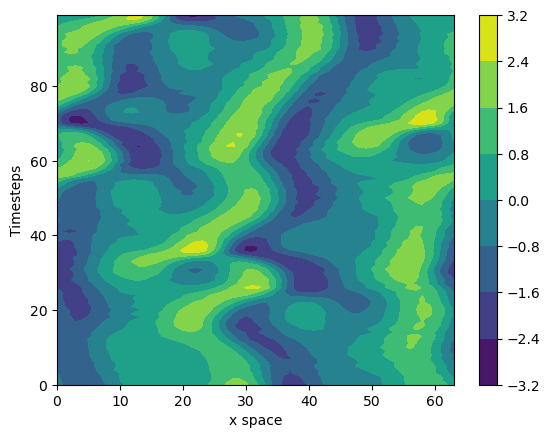

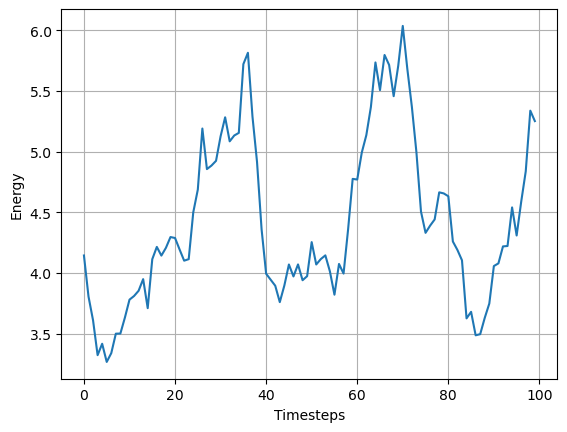

In [17]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 64)
y = np.arange(0, control_time)
X, Y = np.meshgrid(x, y)

plt.figure()
plt.contourf(x,y,obs_data[:control_time])
plt.xlabel("x space")
plt.ylabel("Timesteps")
plt.colorbar()
# plt.

plt.figure()
plt.plot(0.5*np.linalg.norm(obs_data, axis = -1))
plt.grid()
plt.xlabel("Timesteps")
plt.ylabel("Energy")

Text(0, 0.5, 'Energy')

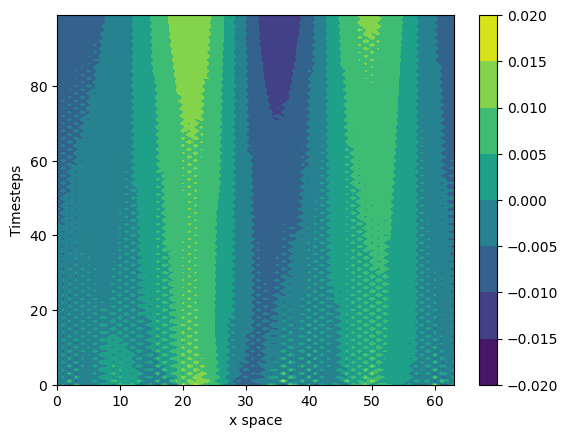

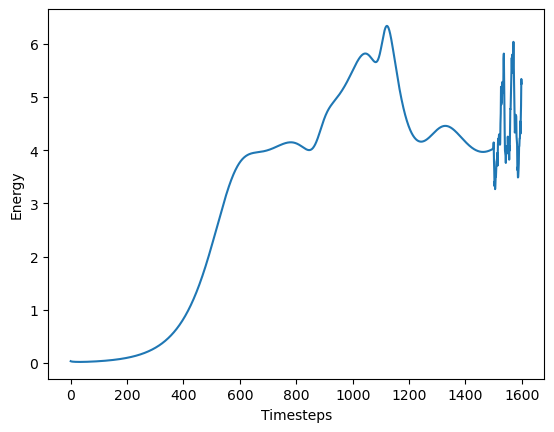

In [18]:
#plot with burnin time included

x = np.arange(0, 64)
y = np.arange(0, control_time)
X, Y = np.meshgrid(x, y)

plt.figure()
plt.contourf(x,y,total_obs_data[:control_time])
plt.xlabel("x space")
plt.ylabel("Timesteps")
plt.colorbar()
# plt.

plt.figure()
plt.plot(0.5*np.linalg.norm(total_obs_data, axis = -1))
plt.xlabel("Timesteps")
plt.ylabel("Energy")

Text(0, 0.5, 'negative Reward')

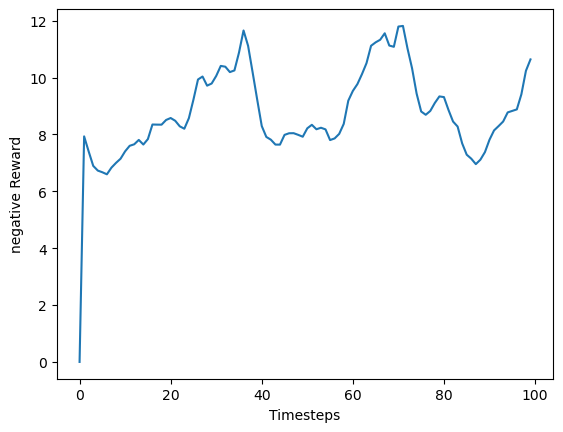

In [19]:
plt.plot(-obs_reward)
plt.xlabel("Timesteps")
plt.ylabel("negative Reward")

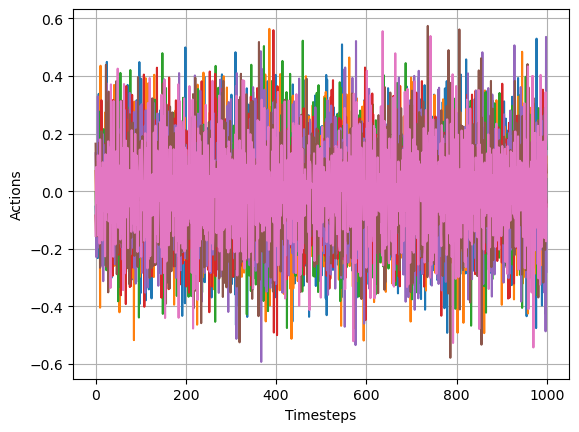

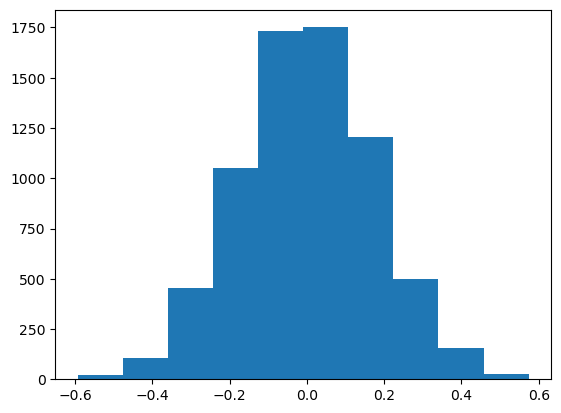

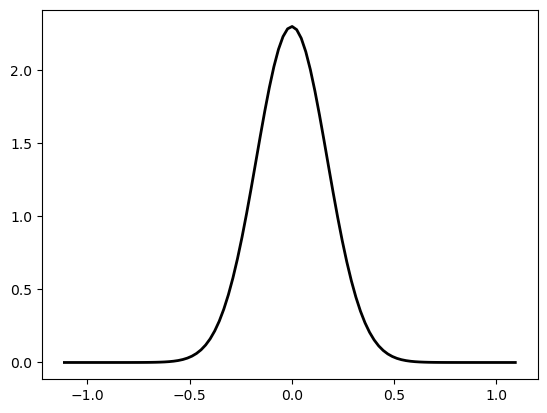

In [96]:
plt.figure()
plt.plot(acts_data)
plt.grid()
plt.xlabel("Timesteps")
plt.ylabel("Actions")

plt.figure()
plt.hist(acts_data.flatten())

plt.figure()
from scipy.stats import norm
mu, std = norm.fit(acts_data.flatten())

# Generate points on the x-axis
xmin = acts_data.flatten().min() - 3 * std
xmax = acts_data.flatten().max() + 3 * std
x = np.linspace(xmin, xmax, 100)

# Generate the PDF values
p = norm.pdf(x, mu, std)

# Plot the PDF curve
plt.plot(x, p, 'k', linewidth=2)

#Evaluating world model

In [31]:
agent.agent.task_behavior.ac

ImagActorCritic(agent/task_behavior/ac)

In [32]:
dataset = agent.dataset(replay.dataset)

In [24]:
data_i = next(dataset)

In [26]:
data_i['is_first']

Array([[ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False,  True]], dtype=bool)

In [15]:
i = next(replay.dataset())
print(replay.online)
i.keys()

False


dict_keys(['vector', 'reward', 'is_first', 'is_last', 'is_terminal', 'action', 'reset', 'id'])

In [21]:
print(np.min(i['action']))

-0.9980621


In [44]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, 64)
y = np.linspace(0, 1, 64)
X, Y = np.meshgrid(x, y)

plt.figure()
plt.contourf(x,y,i['vector'])

plt.figure()
plt.plot(np.linalg.norm(i['vector'], axis = -1))
plt.colorbar()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:9                                                                                    │
│                                                                                                  │
│    6 X, Y = np.meshgrid(x, y)                                                                    │
│    7                                                                                             │
│    8 plt.figure()                                                                                │
│ ❱  9 plt.contourf(x,y,i['vector'])                                                               │
│   10                                                                                             │
│   11 plt.figure()                                                                                │
│   12 plt.plot(np.linalg.norm(i['vector'], axis = -1))                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'int' object is not subscriptable

<Figure size 640x480 with 0 Axes>

In [ ]:
replay.table.keys()